<a href="https://colab.research.google.com/github/arutraj/ML_Basics/blob/main/Live_Class___CNN___Digit_Recognizer_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognizer Dataset Introduction
###It contains the following info:

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:

ImageId,Label
1,3
2,7
3,8
(27997 more lines)


How to install tensor flow on Mac M1/M2 chips?
https://github.com/jeffheaton/t81_558_deep_learning/blob/master/install/tensorflow-install-mac-metal-jan-2023.ipynb


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# convert to one-hot-encoding
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf


sns.set(style='white', context='notebook', palette='deep')

##1. Data preparation


In [2]:
#@title Mount Google drive for datasets access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/Digit_Recognizer_Dataset.zip'

Archive:  /content/Digit_Recognizer_Dataset.zip
  inflating: Digit Recognizer Dataset/test.csv  
  inflating: Digit Recognizer Dataset/train.csv  


In [7]:
# Load the data
# 1.1 Load the Data in Memory
#prefix_path = '/content/Digit_Recognizer_Dataset.zip'
#train = pd.read_csv(prefix_path + '/Digit Recognizer Dataset/train.csv')
#test = pd.read_csv(prefix_path + '/Digit Recognizer Dataset/test.csv')
train = pd.read_csv('/content/Digit Recognizer Dataset/train.csv')
test = pd.read_csv('/content/Digit Recognizer Dataset/test.csv')

In [8]:
train.head(n=10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train.shape

(42000, 785)

In [10]:
test.shape

(28000, 784)

In [12]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)
Y_train.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

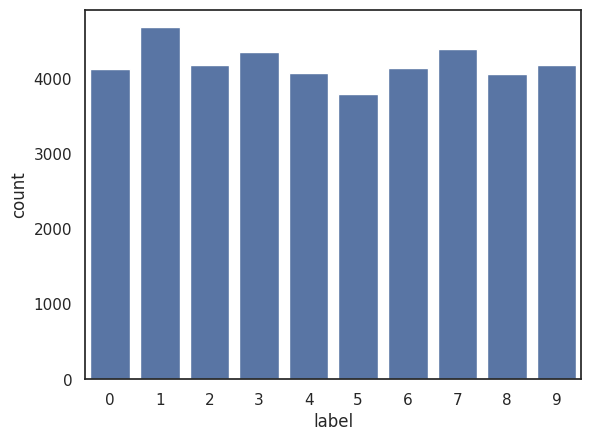

In [13]:
sns.countplot(x='label',data=train);

####Inferences
We have similar counts for the 10 digits.

###1.2 Check for null and missing values

In [14]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [15]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

###1.3 Normalization

###benefit of normalization of inputs;

**Faster Convergence**: Normalization scales all input features (in this case, pixel intensities) to the same range, which can make the training process faster and more efficient. This is because most common activation functions of the neuron in a neural network are linear (or nearly linear) for small input values, and saturate for larger input values. So, if the input values are large (like pixel intensities that range from 0 to 255), the activations of neurons may become saturated, making the network harder to train.
Avoids Gradient Issues: Large input values can lead to large activation values in the neurons of the network. When activation values are large, small changes in the weights can lead to small changes in the output, which can result in tiny gradients. Tiny gradients can lead to a problem called "vanishing gradients", which slows down the training process or causes it to fail altogether.
**Consistent Distribution**: Normalizing ensures that the distribution of features remains more consistent across different features (and different units within a layer). This can prevent certain features from exerting an outsized influence on the training process.
In the specific code you provided, the normalization is achieved by dividing the pixel values by 255 (the maximum RGB code minus the minimum RGB code). This scales the pixel values between 0 and 1. After normalization, the level of granularity remains intact, but the range of values is now much smaller, leading to more stable training and improved model performance


We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [16]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

###1.4 Reshape

In [17]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

###1.5 Label encoding
Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

In [18]:
Y_train = to_categorical(Y_train, num_classes = 10)
Y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

###1.6 Split training and valdiation set

In [19]:
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

Split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42,000 training images of balanced labels, a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

To avoid that, you could use stratify = True option in train_test_split function (Only for >=0.17 sklearn versions).

We can get a better sense for one of these examples by visualising the image and looking at the label.

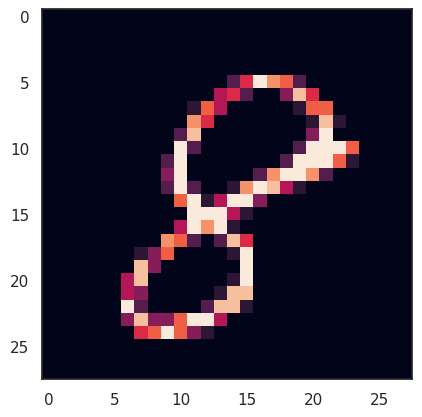

In [20]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

##2. CNN (Convolutional Neural Network)
####2.1 Define the model

Have used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. Have set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end we used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [21]:
#@title Check the number of GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

In [23]:
#@title Set the CNN model
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

# tf.config.experimental.set_memory_growth(gpus[0], True)
# with tf.device('/GPU:0'):

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2))) # 14 x 14 x 32 (H x W x D)
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                activation ='relu')) # 14 x 14 x 64
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                activation ='relu')) # 14 x 14 x 64
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2))) # 7 * 7 * 64
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

###2.2 Set the optimizer and annealer
After adding the layers to our model, the next step involves configuring a score function, a loss function, and an optimization algorithm.

The loss function is defined to quantify the model's performance on labeled images, assessing the error rate between the predicted labels and the observed labels. For categorical classifications (more than two classes), we employ a specific form of loss function known as "categorical_crossentropy."

The optimizer function holds the utmost significance as it continually refines the parameters (such as filter kernel values, weights, and neuron biases) to minimize the loss. RMSprop, with its default values, is an exceptionally effective optimizer. It modifies the Adagrad method in a simple manner to mitigate its aggressive, monotonically decreasing learning rate. While Stochastic Gradient Descent ('sgd') optimizer is another option, it tends to be slower compared to RMSprop.

The metric function employed is "accuracy," which evaluates the model's performance. This metric function operates similarly to the loss function, but the evaluation results from the metric are not used during the model's training phase; they are solely utilized for evaluation purposes.







In [24]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

To enhance the convergence speed of the optimizer and ensure it approaches the global minimum of the loss function more accurately, I implemented an annealing method for the learning rate (LR).

The LR represents the stride taken by the optimizer as it navigates through the landscape of the loss function. A higher LR allows for larger steps, resulting in quicker convergence. However, a high LR may lead to inadequate sampling, potentially causing the optimizer to converge on a local minimum instead of the global minimum.

To address this, it is preferable to have a decreasing learning rate throughout the training process, enabling efficient progress towards the global minimum of the loss function.

To leverage the computational advantages of a high LR while maintaining effective training, we dynamically reduce the LR every X steps (epochs), taking into account whether it is necessary based on the improvement in accuracy.

By utilizing the ReduceLROnPlateau function from Keras.callbacks, we choose to reduce the LR by half if the accuracy does not improve after 3 epochs. This adaptive adjustment of the LR aids in achieving more optimal convergence while maximizing computational efficiency.

In [25]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', #'val_acc',
                                            patience=3, # number of epochs with no improvement after which learning rate will be reduced.
                                            verbose=1,
                                            factor=0.5, # new_lr = lr * factor.
                                            min_lr=0.00001)

In [26]:
epochs = 8 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

###2.3 Data augmentation
To address the issue of overfitting, it is necessary to artificially expand our dataset of handwritten digits. By enlarging the existing dataset, we aim to replicate the variations that occur when individuals write digits. This can be achieved by introducing small transformations to the training data.

For instance, these transformations may involve adjusting the digit's position to make it non-centered, altering the scale to mimic different writing styles (e.g., larger or smaller numbers), and introducing rotations to simulate variations in the orientation of the image.

Data augmentation techniques refer to approaches that modify the training data in a manner that changes the array representation while keeping the label unchanged. These techniques encompass a range of popular augmentations, such as grayscale conversions, horizontal and vertical flips, random crops, color adjustments, translations, rotations, and more.

By applying a few of these transformations to our training data, we can effectively increase the number of training examples by two or three times, thereby creating a highly robust model.

The impact of data augmentation is significant. Without employing data augmentation, the achieved accuracy was 98.114%. However, by incorporating data augmentation techniques, the accuracy improved significantly to 99.67%.

In [27]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

For the data augmentation, we chose to :

Randomly rotate some training images by 10 degrees

*   Randomly Zoom by 10% some training images
*   Randomly shift images horizontally by 10% of the width
*   Randomly shift images vertically by 10% of the height
*   Randomly shift images vertically by 10% of the height

We did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

In [28]:
loss=tf.keras.losses.MeanSquaredError()

In [29]:
# Fit the model
model.compile(optimizer, loss)
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),epochs = epochs, validation_data = (X_val,Y_val),
verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[learning_rate_reduction])

Epoch 1/8
439/439 - 261s - loss: 0.0282 - val_loss: 0.0048 - lr: 0.0010 - 261s/epoch - 595ms/step
Epoch 2/8
439/439 - 250s - loss: 0.0085 - val_loss: 0.0029 - lr: 0.0010 - 250s/epoch - 570ms/step
Epoch 3/8
439/439 - 246s - loss: 0.0061 - val_loss: 0.0020 - lr: 0.0010 - 246s/epoch - 561ms/step
Epoch 4/8
439/439 - 248s - loss: 0.0049 - val_loss: 0.0022 - lr: 0.0010 - 248s/epoch - 564ms/step
Epoch 5/8
439/439 - 245s - loss: 0.0045 - val_loss: 0.0019 - lr: 0.0010 - 245s/epoch - 558ms/step
Epoch 6/8
439/439 - 243s - loss: 0.0039 - val_loss: 0.0019 - lr: 0.0010 - 243s/epoch - 554ms/step
Epoch 7/8
439/439 - 244s - loss: 0.0036 - val_loss: 0.0016 - lr: 0.0010 - 244s/epoch - 557ms/step
Epoch 8/8
439/439 - 249s - loss: 0.0033 - val_loss: 0.0013 - lr: 0.0010 - 249s/epoch - 567ms/step


##3. Evaluate the model
###3.1 Confusion matrix
Confusion matrix can be very helpfull to see your model drawbacks.

132/132 [==============================] - 6s 45ms/step


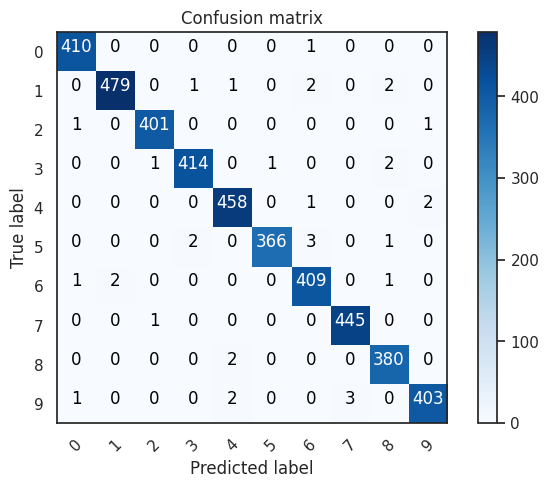

In [30]:
# alternative from sklearn.metrics import plot_confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))


Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4200 images).

However, it seems that our CNN has some little troubles with the 4 digits, they are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate for errors.

The most important errors . For that purpose we need to get the difference between the probabilities of real value and the predicted ones in the results.



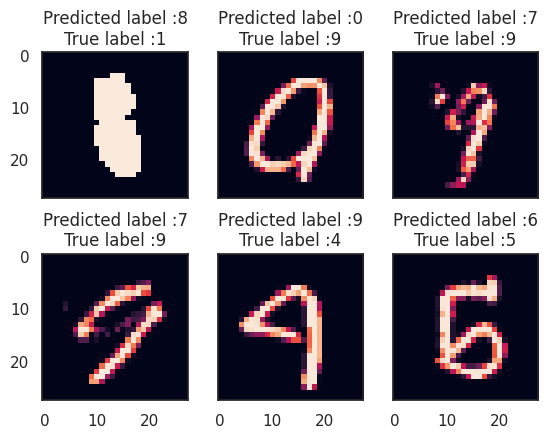

In [32]:
# Display some error results

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)


In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 [==============================] - 49s 55ms/step


In [ ]:
results.head()

0    1
1    1
2    1
3    1
4    4
Name: Label, dtype: int64